In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

In [11]:
# Want to investigate 3 questions:
# 1) Are there large seasonal variations? Which weekdays are cheapest / most expensive? 
# 2) How strong is the correlation between review score and price paid?  Score / $ ratio
# 3) What is my expected revenue with an airbnb listing?

In [12]:
# Read in data to separate dataframes
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [13]:
# View and start editing / formatting data frames
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [14]:
calendar.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

In [15]:
# Remove some of the number formatting,, and convert to numeric
calendar['price']=calendar['price'].str.replace('$','')
calendar['price']=calendar['price'].str.replace(',','')
calendar['price']=pd.to_numeric(calendar['price'])

In [16]:
calendar.dtypes

listing_id      int64
date           object
available      object
price         float64
dtype: object

In [17]:
# For each date, calculate the average price, and the standard deviation. Also plot each listing as a curve
perdate = calendar.groupby('date')
mean_price = perdate['price'].mean()
number_days = mean_price.size
year_mean = mean_price.mean()
std_price = perdate['price'].std()

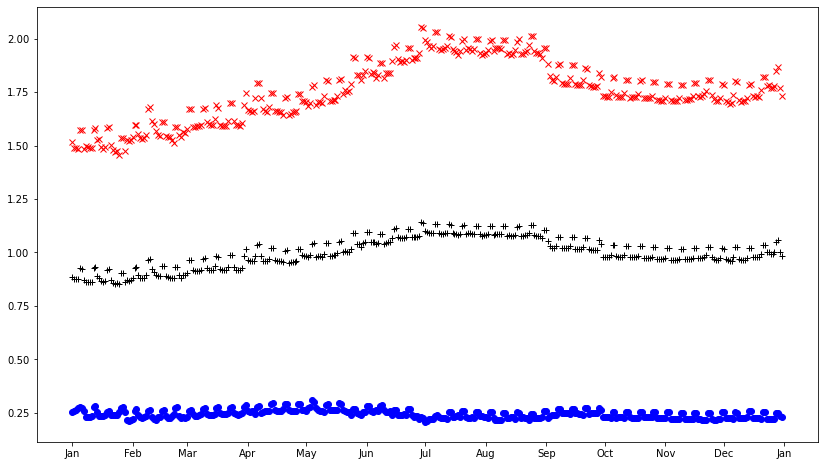

In [18]:
# this plot should answer the seasonal variations .. 
fig, ax = plt.subplots()
ax.plot(mean_price/year_mean,'k+')
ax.plot((mean_price + std_price)/year_mean, 'rx')
ax.plot((mean_price - std_price)/year_mean, 'bo')

# Below code is stolen
# Make ticks on occurrences of each month:
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# '%b' means month as locale’s abbreviated name

fig.set_size_inches(14, 8)

In [19]:
# See if we can plot average price per weekday
calendar['date'] = pd.to_datetime(calendar['date'])
# translate date to a weekday, 0 = Monday, 6 = Sunday
calendar['week_day'] = calendar['date'].dt.weekday
weekdaymean = calendar.groupby('week_day')['price'].mean()
weekmean = weekdaymean.mean()

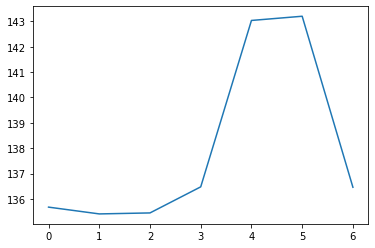

In [20]:
fig, ax = plt.subplots()
ax.plot(weekdaymean)

In [24]:
#2 To answer this we need to merge the listings and calendar data frames. For each listing, calculate the average price and the average score
# For each id, calculate the average rental price from calendar df, add to a new df consisting of id, score and avg price

In [25]:
ids = listings['id'].unique()

In [26]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [27]:
i = 278830


In [28]:
output = pd.DataFrame(columns=['id','avg_price','avg_review_score'])
for i in ids:
    avg_price = calendar.loc[calendar['listing_id']==i]['price'].mean()
    review_score = listings.loc[listings['id']==i]['review_scores_value'].mean()
    # add i, avg_price, review_score as new entry to df
    output = output.append({'id': i, 'avg_price': avg_price, 'avg_review_score': review_score}, ignore_index=True)

In [29]:
output.head()

,id,avg_price,avg_review_score
0,241032.0,85.000000,10.0
1,953595.0,170.931271,10.0
2,3308979.0,1301.818182,10.0
3,7421966.0,100.000000,NaN
4,278830.0,462.739726,9.0


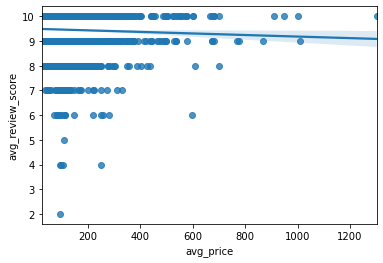

In [39]:
ax = sns.regplot(x="avg_price", y="avg_review_score", data=output)

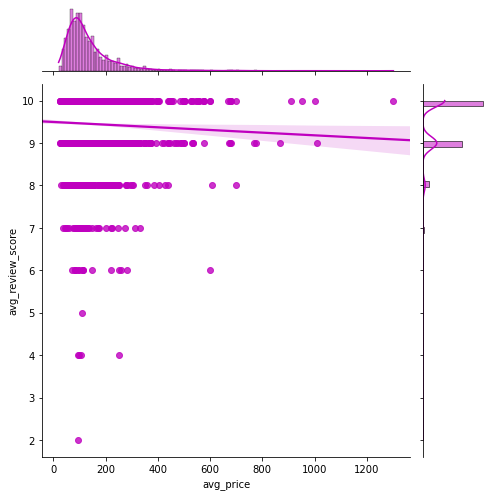

In [42]:
tips = sns.load_dataset("tips")
g = sns.jointplot(x="avg_price", y="avg_review_score", data=output,
                  kind="reg", truncate=False,
                  color="m", height=7)

In [21]:
taken = calendar.loc[calendar['available']=='t'].count()['available']
free = calendar.loc[calendar['available']=='f'].count()['available']
taken / (free + taken)

0.6706100160020666

In [22]:
# Average occupancy rate 67% .. what is average price for the nights when taken? 

In [43]:
calendar['price'].mean() 

137.94485855103355

In [23]:
calendar['price'].sum() / taken
# expected income per year is then:
calendar['price'].mean() * (taken / (free + taken)) * number_days

33765.129387113666